In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score

from lightgbm import LGBMClassifier
from shapmat.abundance_filter import ab_filter

import glob, os
from collections import defaultdict

In [5]:
### SUBSPECIES-LEVEL DATA ###

sample_metadata_subsp = pd.read_csv('../data/CRC_metadata.tsv',sep='\t',index_col=0)
sample_metadata_subsp = sample_metadata_subsp.query("study_condition != 'adenoma'")


relab_subsp = pd.read_csv("../data/combined_relab.tsv",sep='\t',index_col=0)
relab_subsp.index = relab_subsp.index.astype(str).str.rjust(10,'0')
relab_subsp = relab_subsp.T
relab_subsp = relab_subsp.loc[relab_subsp.index.isin(sample_metadata_subsp.index)]
sample_metadata_subsp = sample_metadata_subsp.loc[relab_subsp.index]

In [7]:
### SPECIES-LEVEL DATA ###


profiles = ['../data/profiles/2021-03-31.FengQ_2015.relative_abundance.tsv',
           '../data/profiles/2021-10-14.YachidaS_2019.relative_abundance.tsv',
           '../data/profiles/2021-03-31.YuJ_2015.relative_abundance.tsv',
           '../data/profiles/2021-03-31.ThomasAM_2018a.relative_abundance.tsv',
           '../data/profiles/2021-03-31.WirbelJ_2018.relative_abundance.tsv',
           '../data/profiles/2021-03-31.ZellerG_2014.relative_abundance.tsv',
           '../data/profiles/2021-03-31.VogtmannE_2016.relative_abundance.tsv']

profiles = [pd.read_csv(relab_path,sep='\t',index_col=0) for relab_path in profiles]
profiles = pd.concat(profiles).T.fillna(0)
profiles = profiles.groupby(level=0,axis=1).sum()

relab_sp = profiles.div(profiles.sum(1),axis=0)

sample_metadata_sp = pd.read_csv('../data/2023_curatedmetadata.csv')

YachidaS_2019 = sample_metadata_sp.query('study_name == "YachidaS_2019"')
YuJ_2015 = sample_metadata_sp.query('study_name == "YuJ_2015"')
FengQ_2015 = sample_metadata_sp.query('study_name == "FengQ_2015"')
ThomasAM_2018a = sample_metadata_sp.query('study_name == "ThomasAM_2018a"')
WirbelJ_2018 = sample_metadata_sp.query('study_name == "WirbelJ_2018"')
ZellerG_2014 = sample_metadata_sp.query('study_name == "ZellerG_2014"')
VogtmannE_2016 = sample_metadata_sp.query('study_name == "VogtmannE_2016"')
            
            
YuJ_2015['sample_id'] = YuJ_2015['sample_id'].str.replace("-",'.')
ZellerG_2014['sample_id'] = ZellerG_2014['sample_id'].str.replace("-",'.')
WirbelJ_2018['sample_id'] = WirbelJ_2018['sample_id'].str.replace("-",'.')
VogtmannE_2016['sample_id'] = VogtmannE_2016['sample_id'].str.replace("-",'.')


sample_metadata_sp = pd.concat([YachidaS_2019,YuJ_2015,FengQ_2015,ThomasAM_2018a,WirbelJ_2018,ZellerG_2014,VogtmannE_2016])
sample_metadata_sp = sample_metadata_sp.set_index("sample_id")[['study_name','study_condition']]

sample_metadata_sp = sample_metadata_sp.loc[sample_metadata_sp['study_condition'].isin(['control','CRC'])]


relab_sp = relab_sp.loc[relab_sp.index.isin(sample_metadata_sp.index)]
sample_metadata_sp = sample_metadata_sp.loc[sample_metadata_sp.index.isin(relab_sp.index)]

sample_metadata_sp = sample_metadata_sp.rename(columns = {"study_name":"study"})

relab_sp = relab_sp.fillna(0)

name_mapping = dict(zip(relab_sp.columns, range(len(relab_sp.columns))))
relab_sp.columns = relab_sp.columns.map(name_mapping)

In [8]:
relab_sp = relab_sp.reset_index()
relab_sp.loc[relab_sp['index'].str.contains("VF"),'index'] = relab_sp.loc[relab_sp['index'].str.contains("VF")]['index'].str.split("_",expand=True)[1]
relab_sp = relab_sp.set_index('index',drop=True)

In [9]:
sample_metadata_sp = sample_metadata_sp.reset_index()
sample_metadata_sp.loc[sample_metadata_sp['sample_id'].str.contains("VF"),'sample_id'] = sample_metadata_sp.loc[sample_metadata_sp['sample_id'].str.contains("VF")]['sample_id'].str.split("_",expand=True)[1]
sample_metadata_sp = sample_metadata_sp.set_index('sample_id',drop=True)

In [10]:
overlapping_samples = set(sample_metadata_subsp.sample_id_final).intersection(set(sample_metadata_sp.index))

sample_metadata_sp = sample_metadata_sp.loc[overlapping_samples]
sample_metadata_subsp = sample_metadata_subsp.loc[sample_metadata_subsp.sample_id_final.isin(overlapping_samples)]

In [11]:
sample_metadata_subsp.study.value_counts()

YachidaS_2019     508
YuJ_2015          127
ZellerG_2014      114
FengQ_2015        107
VogtmannE_2016    104
WirbelJ_2018       81
ThomasAM_2018a     42
Name: study, dtype: int64

In [12]:
sample_metadata_sp.study_condition.value_counts()

control    553
CRC        530
Name: study_condition, dtype: int64

In [13]:
sample_metadata_subsp.study_condition.value_counts()

control    553
CRC        530
Name: study_condition, dtype: int64

In [14]:
relab_sp = relab_sp.loc[sample_metadata_sp.index]
relab_subsp = relab_subsp.loc[sample_metadata_subsp.index]

In [15]:
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score
import json

def lodo_train_test_split(relab, sample_metadata, test_study):
    X_train = relab.loc[sample_metadata.query('study != @test_study').index]
    y_train = sample_metadata.query('study != @test_study')['study_condition']


    X_test = relab.loc[sample_metadata.query('study == @test_study').index]
    y_test = sample_metadata.query('study == @test_study')['study_condition']
    
    return X_train, y_train, X_test, y_test

def train_models(relab, sample_metadata,median_importance, data_type, test_study = None):
    
    output_df = pd.DataFrame()
    feature_importance = pd.DataFrame()
    
    random_states =  [424, 646, 968, 375, 603, 508, 251, 598, 946, 851]
    ### LBGM ###
    # specify your parameters 
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 3,
        'learning_rate': 0.01,
        #'feature_fraction': 0.9,
        'bagging_fraction':0.8,
        'bagging_freq': 5,
        'verbose': 0
    }
    for random_state in random_states:
        if test_study != None:
            X_train, y_train, X_test, y_test = lodo_train_test_split(relab, sample_metadata, test_study)
        else:
            X_train, X_test, y_train, y_test = train_test_split(relab, sample_metadata.study_condition, test_size=0.3, random_state=random_state)
        
        
        
        
        y_train = y_train.map({"control":0,"CRC":1})
        y_test = y_test.map({"control":0,"CRC":1})

        X_train_filtered = ab_filter(X_train,abundance_threshold=0,prevalence_threshold=0.85)
        X_test_filtered = X_test[X_train_filtered.columns]
        
        max_features =  median_importance.query("test_study == @test_study").Feature.nunique()
        for n_top_features in [2,4,8,16,32,64,128,max_features]:
        
            top_features = median_importance.query('test_study == @test_study').sort_values('Value',ascending=False).iloc[:n_top_features].Feature
            
            X_train_filtered_top_subsp = X_train_filtered[top_features]
            X_test_filtered_top_subsp = X_test_filtered[top_features]
            
            # create dataset for lightgbm
            lgbm = LGBMClassifier(**params, n_estimators=1000, random_state = random_state)

            # train the model
            print(top_features)
            lgbm.fit(X_train_filtered_top_subsp, y_train)

            # predict the probabilities of the positive class
            y_pred_proba = lgbm.predict_proba(X_test_filtered_top_subsp)[:, 1]
            y_pred = lgbm.predict(X_test_filtered_top_subsp)

            # compute ROC AUC from prediction scores
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            output_df = pd.concat([output_df, pd.DataFrame({"model":"LBGM", "test_study":test_study, 'data_type':data_type,"roc_auc":roc_auc,
                                                           "accuracy":accuracy, "recall":recall, "f1_score":f1,"top_features":top_features,
                                                           "n_top_features":n_top_features,
                                                           'random_state':random_state},
                                                           index=[data_type])], axis=0)

    
    return output_df
    

In [17]:
subspecies_importance = pd.read_csv("../LODO/subspecies_importance.tsv",sep='\t')
subspecies_importance.Feature = subspecies_importance.Feature.astype(str).str.rjust(10,'0')

In [18]:
median_importance = pd.DataFrame(subspecies_importance.groupby(['test_study','Feature']).median()['Value']).reset_index()

In [98]:
performance_subspecies = pd.DataFrame()
for test_study in sample_metadata_subsp.study.unique():
    study_performance = train_models(relab_subsp, sample_metadata_subsp,median_importance, 'subspecies', test_study)
    
    performance_subspecies = pd.concat([performance_subspecies, study_performance],axis=0)

3038    3712001001
3005    2795001001
Name: Feature, dtype: object
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: 

In [72]:
grouped_df = performance_subspecies.groupby(['test_study', 'n_top_features'])['roc_auc'].agg(['median', 'std']).reset_index()
merged_df = pd.merge(performance_subspecies, grouped_df, how='left', on=['test_study', 'n_top_features'])
merged_df.loc[merged_df['n_top_features'] > 128,'n_top_features'] = 'all'

In [76]:
merged_df['n_top_features'] = merged_df['n_top_features'].astype(str)

In [19]:
#merged_df.to_csv("top_features_performance.tsv",sep='\t',index=False)

merged_df = pd.read_csv("top_features_performance.tsv",sep='\t')

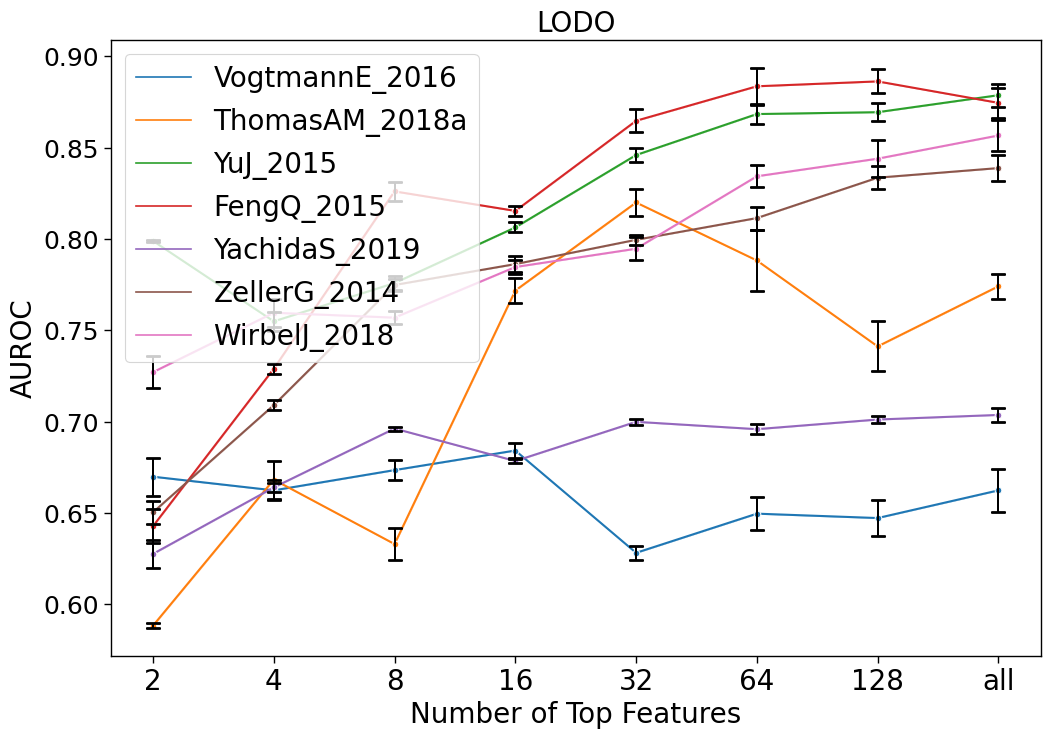

In [22]:
# Creating the plot

sns.set_context('paper')
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='n_top_features', y='median', hue='test_study', marker='o',linewidth=1.5)

# Adding error bars
for name, group in merged_df.groupby('test_study'):
    plt.errorbar(group['n_top_features'], group['median'], yerr=group['std'], fmt='none', capsize=5, label='_nolegend_',color='black')

plt.xlabel('Number of Top Features',fontsize=20)
plt.ylabel('AUROC',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

plt.title("LODO", fontsize=20)
plt.legend(title='',fontsize=20,loc=2)
#plt.savefig("LODO_top_features.svg",bbox_inches='tight')